# **Claims Severity Analysis**

## DSA 6100 Final Project

### Completed by:
Karim Al Zeer Alhusaini

Nalini Kethineni

________________________________________________________________________________________________________________________

#### Loading Required Libraries

In [1]:
## Libraries ---------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import warnings; 
warnings.filterwarnings("ignore") # ignore warnings for the purpose of readability

## Sci-Kit Learn
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

## Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error

#### Uploading Data

In [2]:
## Uploading data
tData = pd.read_csv("train.csv")
trainData = tData.loc[tData['loss'] <= 30000]
#act_testData = pd.read_csv("test.csv")

#### Remove cont12 due to high correlation

In [3]:
## Removing unnecessary cont12 variables
trainData.drop('cont12',axis=1,inplace=True)
#act_testData.drop('cont12',axis=1,inplace=True)

In [4]:
## Copying data for one-hot encoding
OHE_TrainDataCopy = trainData
#OHE_testDataCopy = act_testData

#### Remove ID Index variable

In [5]:
## Remove ID variable since it is only an index
trainData.drop('id',axis=1,inplace=True)
#testDataIDs = act_testData['id']
#act_testData.drop('id',axis=1,inplace=True)

#### Plotting Data Distributions

In [6]:
sns.set(style="whitegrid", color_codes=True)
dftrain = pd.read_csv("train.csv")

# Get Categorical Columns
nonnumcols=[]
for col in dftrain.columns:
    if col.startswith('cat'):
        nonnumcols.append(col)

# Get Categorical Columns
numcols=[]
for col in dftrain.columns:
    if col.startswith('cont'):
        numcols.append(col)

#### Plotting Categorical Data Distributions

In [ ]:
ncol = 4
nrow = 4
for i in range(nrow):
    fig,axs = plt.subplots(nrows=1,ncols=ncol,sharey=True,figsize=(8, 5))
    cols = nonnumcols[i*ncol:ncol*(i+1)]
    for i in range(len(axs)):
        axs[i].set(yscale="log")
        sns.boxplot(x=cols[i], y="loss", data=dftrain, ax=axs[i], 
                    palette="Set3").set_title(cols[i] + " Distribution", weight='bold').set_fontsize('12')
        axs[i].set(xlabel=cols[i], ylabel='log(loss)')

#### Plotting Continuous Data Densities

In [ ]:
sns.set(style="whitegrid", color_codes=True)
ncol = 7
nrow = 2
for i in range(nrow):
    fig,axs = plt.subplots(nrows=1,ncols=ncol,sharey=True,figsize=(14, 5))
    cols = numcols[i*ncol:ncol*(i+1)]
    for i in range(len(axs)):
        sns.distplot(dftrain[cols[i]], ax=axs[i], hist=False, 
                     color="y").set_title(cols[i] + " Distribution", weight='bold').set_fontsize('11')
        xlabel=cols[i]
        axs[i].set(xlabel=xlabel, ylabel='Density')

#### One Hot Encoding of data

In [7]:
## Encoding all categorical data

# Categorial encode data both by
#   - Label encoding ([A,B,B,C] -> [1,2,2,3])
#   - One-hot-encoding: creates dummy variables ([A,B,B,C] -> [A=[1,0,0,0], B=[0,1,1,0], C=[0,0,0,1]])

## Create an encoding function
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


# 1- Concatenate training and testing data
#Data = pd.concat([trainData, act_testData])
Data = trainData

# 2- Encode all categorical variables
OneHotEncoded_Data = pd.get_dummies(Data)
columns2encode = []
for i in range(116):
    columns2encode.append(list(Data)[i])
Data = MultiColumnLabelEncoder(columns2encode).fit_transform(Data)

#### Split Data into Training and Testing Sets

In [8]:
# 3- Split data into training and testing again
#   *3.a one-hot-encoding
OneHotEncoded_trainData = OneHotEncoded_Data[:trainData.shape[0]]
#OneHotEncoded_testData = OneHotEncoded_Data[trainData.shape[0]:]
#OneHotEncoded_testData.drop('loss',axis=1,inplace=True)
#    *3.b label encoding ([A,B,B,C] -> [1,2,2,3])
trainData = Data[:trainData.shape[0]]
#testData = Data[trainData.shape[0]:]
#testData.drop('loss',axis=1,inplace=True)

# 4- Splitting into training, test and validation set 80/20

#  One-hot-encoding
OneHotEncoded_y_trainData = OneHotEncoded_trainData['loss']
OneHotEncoded_X_trainData = OneHotEncoded_trainData[OneHotEncoded_trainData.columns.difference(['loss'])]
OneHotEncoded_X_train, OneHotEncoded_X_test, OneHotEncoded_y_train, OneHotEncoded_y_test = \
train_test_split(OneHotEncoded_X_trainData, OneHotEncoded_y_trainData, test_size=0.2, random_state=20)

#  Label encoding
y_trainData = trainData['loss']
X_trainData = trainData[trainData.columns.difference(['loss'])]
X_train, X_test, y_train, y_test = train_test_split(X_trainData, y_trainData, test_size=0.2, random_state=20)

#### Correlation Matrix

[Text(0, 0.5, 'cont1'),
 Text(0, 1.5, 'cont10'),
 Text(0, 2.5, 'cont11'),
 Text(0, 3.5, 'cont13'),
 Text(0, 4.5, 'cont14'),
 Text(0, 5.5, 'cont2'),
 Text(0, 6.5, 'cont3'),
 Text(0, 7.5, 'cont4'),
 Text(0, 8.5, 'cont5'),
 Text(0, 9.5, 'cont6'),
 Text(0, 10.5, 'cont7'),
 Text(0, 11.5, 'cont8'),
 Text(0, 12.5, 'cont9')]

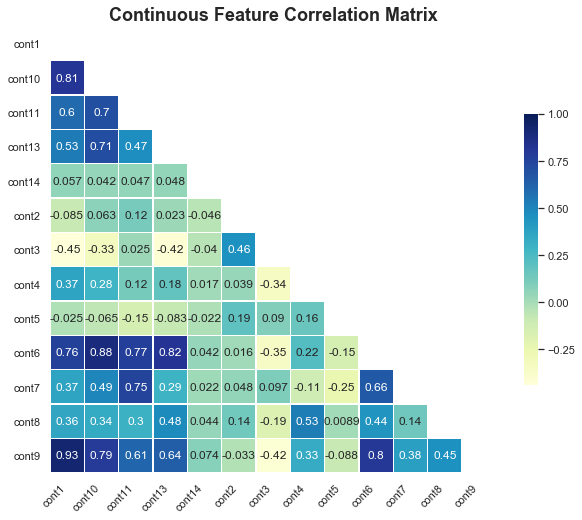

In [9]:
## Correlation Matrix
f,ax = plt.subplots(figsize=(10, 10))
x_cont = X_trainData.iloc[:,116:129]
corr = x_cont.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot=True, mask=mask, linewidths=.5,ax=ax, cmap="YlGnBu", 
            square=True,  cbar_kws={"shrink": .5})
ax.set_title('Continuous Feature Correlation Matrix', fontsize=18, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,
    horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
    horizontalalignment='right')

#### Distributions of Target Variable

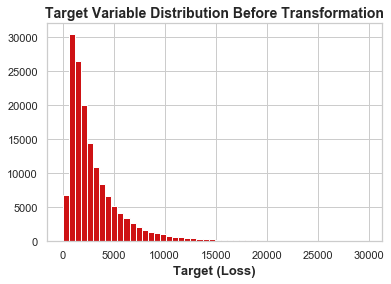

In [10]:
## Log transformation for output variables

## Distribution before log transformation
plt.hist(y_train,50,color="#ce1214")
plt.xlabel("Target (Loss)",  weight='bold').set_fontsize('13')
plt.title("Target Variable Distribution Before Transformation",  weight='bold').set_fontsize('14')
plt.show()

#### Distribution of Log Transformed Target Variable

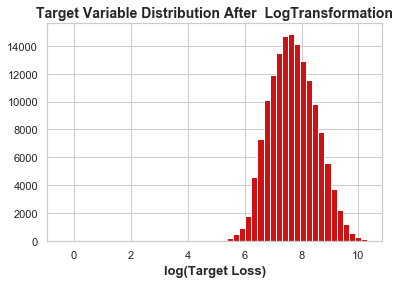

In [11]:
## Distribution after log transformation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)
plt.hist(y_train_log,50,color="#ce1214")
plt.xlabel("log(Target Loss)",  weight='bold').set_fontsize('13')
plt.title("Target Variable Distribution After  LogTransformation",  weight='bold').set_fontsize('14')
plt.show()

#### Principal Component Analysis

In [ ]:
## Principal Component Analysis - Dimensionality Reduction
pca = PCA(n_components=600).fit(OneHotEncoded_X_train)
pca2 = pca.transform(OneHotEncoded_X_train)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of Principal Components",  weight='bold').set_fontsize('13')
plt.ylabel("% of Variance Explained",  weight='bold').set_fontsize('13')
plt.title("% Variance Explained by PC",  weight='bold').set_fontsize('14')

#### Plotting PCA Chart

In [ ]:
## Plotting the PCA
plt.subplots(figsize=(11, 9))
plt.scatter(pca2[:,0],pca2[:,1],cmap=cm.tab20,c = y_train_log,s=10)
plt.xlabel('PC 1',  weight='bold').set_fontsize('13')
plt.ylabel('PC 2',  weight='bold').set_fontsize('13')
plt.title('Principal Component Analysis',  weight='bold').set_fontsize('14')
cbar = plt.colorbar()
cbar.set_label("log-loss")
plt.show()

#### Split Data into Training and Validation Sets

In [ ]:
# Split data into training set (80%) and testing set (20%)
X_train_, X_val_, y_train_log_, y_val_log_ = train_test_split(
    X_train, y_train_log , test_size=0.2, random_state=20)

#### Model 1: Linear Regression

In [12]:
## Simple Linear Regression

# Multi-labeled dataset with log(Loss) as an output
reg = linear_model.LinearRegression(fit_intercept=False, normalize=True)
reg.fit(X_train, y_train_log)
y_pred_train_log = reg.predict(X_train)
y_pred_test_log = reg.predict(X_test)
print('--------------------------------------------------------------')
print("Results from simple regression on the multi-labeled dataset:")
print('Training MAE using log transformation:', 
      np.average(abs(np.exp(y_train_log)-np.exp(y_pred_train_log))))
print('Test MAE using log transformation:', 
      np.average(abs(np.exp(y_test_log)-np.exp(y_pred_test_log))))
print('--------------------------------------------------------------')

--------------------------------------------------------------
Results from simple regression on the multi-labeled dataset:
Training MAE using log transformation: 1292.111686606511
Test MAE using log transformation: 1286.7015046116433
--------------------------------------------------------------


In [13]:
sss = reg.score(X_train, y_train_log)

In [14]:
sss

0.4683169273130491

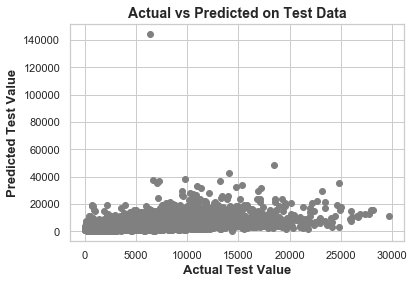

In [15]:
# Plotting Actual vs Predicted 

# Testing Set
plt.scatter(np.exp(y_test_log), np.exp(y_pred_test_log),  color='gray')
plt.xlabel('Actual Test Value',  weight='bold').set_fontsize('13')
plt.ylabel('Predicted Test Value',  weight='bold').set_fontsize('13')
plt.title('Actual vs Predicted on Test Data',  weight='bold').set_fontsize('14')
# Training Set
#plt.scatter(np.exp(y_train_log), np.exp(y_pred_train_log),  color='gray')
plt.show()

In [ ]:
# Training Set
plt.scatter(np.exp(y_train_log), np.exp(y_pred_train_log),  color='red')
plt.xlabel('Actual Training Value',  weight='bold').set_fontsize('13')
plt.ylabel('Predicted Training Value',  weight='bold').set_fontsize('13')
plt.title('Actual vs Predicted on Training Data',  weight='bold').set_fontsize('14')
plt.show()

#### Model 1-b: PC Regression

In [17]:
OneHotEncoded_X_train, OneHotEncoded_X_val, y_train_log_, y_val_log = train_test_split(
    OneHotEncoded_X_trainData, OneHotEncoded_y_trainData, test_size=0.2, random_state = 20)
dimensions = np.array([600])
DIM_REG_train_error = np.zeros(dimensions.shape[0])
DIM_REG_val_error = np.zeros(dimensions.shape[0])
for d in range(dimensions.shape[0]):
	pca = PCA(n_components=dimensions[d]).fit(OneHotEncoded_X_trainData)
	XD_REG_train = pca.transform(OneHotEncoded_X_train)
	XD_REG_val = pca.transform(OneHotEncoded_X_val)

	reg = linear_model.LinearRegression()
	reg.fit(XD_REG_train, y_train_log)
	y_pred_train_log = reg.predict(XD_REG_train)
	y_pred_val_log = reg.predict(XD_REG_val)
	DIM_REG_train_error[d] = np.average(abs(np.exp(y_train_log)-np.exp(y_pred_train_log)))
	DIM_REG_val_error[d] = np.average(abs(y_val_log-np.exp(y_pred_val_log)))


In [18]:
reg.score(XD_REG_train, y_train_log)

0.51984978661442

In [ ]:
# Plotting PC Regression
plt.plot(dimensions[[0,1,2,3,4,5,6]],DIM_REG_train_error[[0,1,2,3,4,5,6]], label="Training Error")
plt.plot(dimensions[[0,1,2,3,4,5,6]],DIM_REG_val_error[[0,1,2,3,4,5,6]], label="Validation Error")
plt.xlabel('# of Principal Components Used')
plt.ylabel('Mean Absoulte Error')
plt.title('Principal Component Regression',  weight='bold').set_fontsize('14')
plt.legend()
plt.show()

#### Model 2: Ridge & Lasso Regressions

In [ ]:
## Shrinkage Methods: Ridge & Lasso Regressions
def plot_hyp_param_search(alphas, train_MAE, val_MAE, title):
    plt.plot(np.log10(alphas),train_MAE,label='Training MAE')
    plt.plot(np.log10(alphas),val_MAE,label='Validation MAE')
    plt.xlabel('$\lambda$')
    plt.ylabel('Mean Absolute Error')
    plt.title(title)
    plt.legend()
    plt.show()
    
def hyp_param_search(model, alphas, X_train_, y_train_log_, X_val_, y_val_log_, name):
    train_MAE = np.zeros(alphas.shape[0])
    val_MAE = np.zeros(alphas.shape[0])
    for a in range(alphas.shape[0]):
        reg = model(alpha = alphas[a])
        reg.fit(X_train_, y_train_log_)
        y_pred_train_log = reg.predict(X_train_)
        y_pred_val_log = reg.predict(X_val_)
        train_MAE[a] = np.average(abs(np.exp(y_train_log_)-np.exp(y_pred_train_log)))
        val_MAE[a] = np.average(abs(np.exp(y_val_log_)-np.exp(y_pred_val_log)))
    
    plot_hyp_param_search(alphas, train_MAE, val_MAE, 
                      title = "Hyperparameter search for " + name + " regression")
    
    return alphas[np.argmin(val_MAE)]

def eval_perf(reg, X_train, y_train_log, X_test, y_test_log):
    print('--------------------------------------------------------------------------------------')
    reg.fit(X_train, y_train_log)
    y_pred_train_log = reg.predict(X_train)
    y_pred_test_log = reg.predict(X_test)
    print("Results from simple regression on the multi-labeled dataset:")
    print('Training MAE using log transformation:', 
          np.average(abs(np.exp(y_train_log)-np.exp(y_pred_train_log))))
    print('test MAE using log transformation:', 
          np.average(abs(np.exp(y_test_log)-np.exp(y_pred_test_log))))
    print('--------------------------------------------------------------------------------------')

# Hyperparameter search
alphas = 1/np.power(10,np.arange(20))
alpha_Ridge = hyp_param_search(linear_model.Ridge, alphas, X_train_, y_train_log_,
                               X_val_, y_val_log_, name="Ridge")
alpha_Lasso = hyp_param_search(linear_model.Lasso, alphas, X_train_, y_train_log_, 
                               X_val_, y_val_log_, name="Lasso")

# Evaluating the performance of our best hyperparameter on the test set
ridgeReg = linear_model.Ridge(alpha = alpha_Ridge)
eval_perf(ridgeReg, X_train, y_train_log, X_test, y_test_log)
lassoReg = linear_model.Lasso(alpha = alpha_Lasso)
eval_perf(lassoReg, X_train, y_train_log, X_test, y_test_log)

In [ ]:

lassoReg.score(X_train, y_train_log)

#### Model 3: Support Vector Machines (Support Vector Regressor)

In [ ]:
shrinking_factor = 0.01
X_train_small = X_train_[:int(shrinking_factor*X_train_.shape[0])]
y_train_log_small = y_train_log_[:int(shrinking_factor*X_train_.shape[0])]

# Rough search for a good estimate of C on the interval [1,e-6]
C = 1/np.power(10,np.arange(6))
training_MAE = []; test_MAE = []
for c in C:
    SVM = svm.SVR(C=c, kernel='linear', cache_size=1000)
    SVM.fit(X_train_small, y_train_log_small)
    y_train_pred_log = SVM.predict(X_train_small)
    y_val_pred_log = SVM.predict(X_val_)
    training_MAE.append(np.average(abs(np.exp(y_train_log_small) - np.exp(y_train_pred_log))))
    test_MAE.append(np.average(abs(np.exp(y_val_log_) - np.exp(y_val_pred_log))))

plt.plot(np.log10(C), training_MAE,label='training MAE')
plt.plot(np.log10(C), test_MAE,label='validation MAE')
plt.xlabel('log_10(C)')
plt.ylabel('MAE')
plt.legend()
plt.show()

cOpt = C[np.argmin(test_MAE)]
print("Optimal value of c for validation set:", cOpt)

In [ ]:
cOpt = C[np.argmin(test_MAE)]
print("Optimal value of c for validation set:", cOpt)

In [ ]:
plt.plot(np.log10(C), training_MAE,label='training MAE')
plt.plot(np.log10(C), test_MAE,label='validation MAE')
plt.xlabel('log_10(C)',  weight='bold').set_fontsize('12')
plt.ylabel('MAE',  weight='bold').set_fontsize('12')
plt.title('SVM MAE Values for Different C Parameters',  weight='bold').set_fontsize('14')
plt.legend()
plt.show()

#### Evaluate the Performance of SVM

In [ ]:
# Evaluate the model on the test set

# Cashed results
MAE_train = 1296.36
MAE_test = 1308.77

modelAll = False # make true if you can wait ~ 30 mins
if modelAll:
    SVM = svm.SVR(C=cOpt, kernel='linear', cache_size=1000)
    SVM.fit(X_train, y_train_log) 
    y_train_pred_log = SVM.predict(X_train)
    y_test_pred_log = SVM.predict(X_test)
    MAE_train = np.average(abs(np.exp(y_train_log) - np.exp(y_train_pred_log)))
    MAE_test = np.average(abs(np.exp(y_test_log) - np.exp(y_test_pred_log)))
    
print("Training MAE using log transformation:", MAE_train)
print("Test MAE using log transformation:", MAE_test)

#### Model 4: Random Forest Model

In [ ]:
## Random Forest Model

# Gridsearch and model
gridsearch = False
if gridsearch:
    parameters = {
        'max_depth'
        :range(50, 500, 50),
        'max_features':range(10, 20, 2)
    }
    rf = RandomForestRegressor(n_estimators=50, oob_score=False)
    grid = GridSearchCV(rf, parameters)
    grid.fit(X_train, y_train)
    print("Optimal parameters for the grid are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

    # Use our best RF model 
    rf = RandomForestRegressor(
        n_estimators=50,
        max_depth=grid.best_params_['max_depth'],
        max_features=grid.best_params_['max_features'],
        oob_score=False
    )
else:
    # used cashed results from gridsearch
    rf = RandomForestRegressor(n_estimators=50, max_depth=250, max_features=15)

# Fit and test it
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training MAE:",np.average(abs(y_train - y_train_pred)))
print("Test MAE:",np.average(abs(y_test - y_test_pred)))

#### Evaluating the RF Model

In [ ]:
# Explore which features are the most important in RF model
features = list(zip(X_train.columns, rf.feature_importances_))
n = 20
topFeatures = dict(sorted(features, key = lambda x: x[1], reverse=True)[1:n])

fig, ax =  plt.subplots(figsize=(10, 10))
ax.barh(list(topFeatures.keys()), list(topFeatures.values()), color='red', ecolor='black')
ax.set_yticks(list(topFeatures.keys()))
ax.invert_yaxis()
ax.set_xlabel('Importance',  weight='bold').set_fontsize('14')
ax.set_ylabel('Feature',  weight='bold').set_fontsize('14')
ax.set_title("Top {} Features".format(n),  weight='bold').set_fontsize('16')
plt.show()

In [ ]:
print(rf.feature_importances_)
print(len(rf.feature_importances_))
arr = rf.feature_importances_
stuff = arr.argsort()[-10:][::-1]
len(trainData.columns)
temp1 = ['kk','kk','kk','kk','kk','kk','kk','kk','kk','kk']
k = 0
for i in stuff:
	temp1[k] = trainData.columns[i]
	k += 1
temp2 = ['kk','kk','kk','kk','kk','kk','kk','kk','kk','kk']
k = 0
for i in stuff:
	temp2[k] = arr[i]
	k += 1
fig, ax = plt.subplots()
ax.barh(temp1, temp2, color='green', ecolor='black')
ax.set_yticks(temp1)
ax.invert_yaxis()
ax.set_yticklabels(temp1)
ax.set_xlabel('Importance')
plt.show()

In [ ]:
# #Evaluation of various combinations of XGB
# X_train_, X_val_, y_train_log_, y_val_log_ = train_test_split(
#     X_train, y_train_log , test_size=0.2, random_state=20)
# #Import the library
# from xgboost import XGBRegressor

# #Add the n_estimators value to the below list if you want to run the algo
# n_list = numpy.array([])

# for n_estimators in n_list:
#     #Set the base model
#     model = XGBRegressor(n_estimators=n_estimators,seed=seed)
    
#     algo = "XGB"

#     #Accuracy of the model using all features
#     for name,i_cols_list in X_all:
#         model.fit(X_train_,y_train_log_)
#         result = mean_absolute_error(numpy.expm1(Y_val), numpy.expm1(model.predict(X_val[:,i_cols_list])))
#         mae.append(result)
#         print(name + " %s" % result)
        
#     comb.append(algo + " %s" % n_estimators )

# if (len(n_list)==0):
#     mae.append(1169)
#     comb.append("XGB" + " %s" % 1000 )    
    
# ##Set figure size
# plt.rc("figure", figsize=(25, 10))

# ##Plot the MAE of all combinations
# fig, ax = plt.subplots()
# plt.plot(mae)
# ##Set the tick names to names of combinations
# ax.set_xticks(range(len(comb)))
# ax.set_xticklabels(comb,rotation='vertical')
# ##Plot the accuracy for all combinations
# plt.show()    

# #Best estimated performance is 1169 with n=1000

#### Model 5: Neural Network: Multi-Layer Perceptron (MLP)

In [ ]:
## Neural Network: Multi-Layer Perceptron (MLP)

# Re-loading data
trainData = pd.read_csv("train.csv")
submissionData = pd.read_csv("test.csv")

# dropping correlated variables
trainData.drop('cont12',axis=1,inplace=True)
submissionData.drop('cont12',axis=1,inplace=True)

# drop ID but store in submission data
trainData.drop('id',axis=1,inplace=True)
NN_y_train = trainData['loss']
trainData.drop('loss',axis=1,inplace=True)
submissionDataIDs = submissionData['id']
submissionData.drop('id',axis=1,inplace=True)

# one-hot-encoding 
NN_train_Data = pd.get_dummies(trainData)
NN_sub_Data = pd.get_dummies(submissionData)
trainLabels = list(NN_train_Data)
subLabels = list(NN_sub_Data)

for i in range(len(trainLabels)):
    if (not (trainLabels[i] in subLabels)):
        NN_train_Data.drop([trainLabels[i]],axis=1,inplace=True)
        
for i in range(len(subLabels)):
    if (not (subLabels[i] in trainLabels)):
        NN_sub_Data.drop([subLabels[i]],axis=1,inplace=True)

# splitting into training and test set 80/20
OneHotEncoded_X_train, OneHotEncoded_X_test, OneHotEncoded_y_train, OneHotEncoded_y_test = \
train_test_split(NN_train_Data, NN_y_train, test_size=0.2, random_state=20)

# Feed it in as np.arrays
OneHotEncoded_X_train = np.asarray(OneHotEncoded_X_train)
OneHotEncoded_y_train = np.asarray(OneHotEncoded_y_train)
OneHotEncoded_X_test = np.asarray(OneHotEncoded_X_test) 
NN_sub_Data = np.asarray(NN_sub_Data)

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

model = Sequential()
model.add(Dense(500, input_dim=OneHotEncoded_X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(OneHotEncoded_X_train, OneHotEncoded_y_train,
                    epochs=100, batch_size=128, validation_split=0.2, shuffle=True,verbose=1)

# Visualizing the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Mean Absolute Error')
plt.xlabel('Iteration')
plt.legend(['Training', 'Validation'])
plt.show()

y_pred = model.predict(OneHotEncoded_X_test)
test_error = mean_absolute_error(OneHotEncoded_y_test, y_pred)
print("Test MAE:", test_error)

In [ ]:
# Visualizing the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Mean Absolute Error', weight='bold').set_fontsize('14')
plt.xlabel('Iteration', weight='bold').set_fontsize('14')
plt.title('Training of Neural Network', weight='bold').set_fontsize('16')
plt.legend(['Training', 'Validation'])
plt.show()

#### Predict Using The NN Model

In [ ]:
y_pred = model.predict(OneHotEncoded_X_test)
test_error = mean_absolute_error(OneHotEncoded_y_test, y_pred)
print("Test MAE:", test_error)

In [ ]:
# Model the submission set (final test) with NN model (Best performance)
#y_pred_submission = model.predict(NN_sub_Data)
#with open("testSubmissionFile.csv", "w") as subfile:
    #subfile.write("id,loss\n")
    #for i, prediction in enumerate(list(y_pred_submission)):
        #subfile.write("%s,%s\n"%(submissionDataIDs[i],prediction[0]))